<a href="https://colab.research.google.com/github/riccardoc95/PixHomology/blob/main/notebooks/topological_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

This section installs the necessary dependencies for the experiment. The package `pixhomology` is used for computing topological features, which are essential for analyzing the structure of histopathological images.

In [1]:
!pip install pixhomology

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 1.9 MB/s eta 0:00:00


# Data Download

The dataset used in this experiment consists of histopathological images from colorectal cancer tissue samples. The dataset is downloaded from Zenodo and extracted for further processing.

In [2]:
!wget https://zenodo.org/records/53169/files/Kather_texture_2016_larger_images_10.zip
!unzip /content/Kather_texture_2016_larger_images_10.zip

--2025-02-28 09:55:36--  https://zenodo.org/records/53169/files/Kather_texture_2016_larger_images_10.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 742020106 (708M) [application/octet-stream]
Saving to: ‘Kather_texture_2016_larger_images_10.zip’

Kather_texture_2016 100%[===================>] 707.65M  29.3MB/s    in 49s     

2025-02-28 09:56:26 (14.4 MB/s) - ‘Kather_texture_2016_larger_images_10.zip’ saved [742020106/742020106]

Archive:  /content/Kather_texture_2016_larger_images_10.zip
  inflating: Kather_texture_2016_larger_images_10/CRC-Prim-HE-01_APPLICATION.tif  
  inflating: Kather_texture_2016_larger_images_10/CRC-Prim-HE-02-APPLICATION.tif  
  inflating: Kather_texture_2016_larger_images_10/CRC-Prim-HE-03_APPLICATION.tif  
  inflating: Kather_texture_2016_larger_images_10/CRC-Prim-HE-04_APPLICATION.tif  
  in

# Import Libraries

We import essential libraries required for image processing, topological feature extraction, and visualization. These include NumPy for numerical operations, PIL for handling image formats, `pixhomology` for persistent homology computations, and Matplotlib/Seaborn for visualization.

In [3]:
import numpy as np
from PIL import Image
import pixhomology as px
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage.color import label2rgb
import seaborn as sns

from tqdm import tqdm
import os

# Load and Preprocess Image

In this step, we load a TIFF histopathology image and convert it into a grayscale representation.

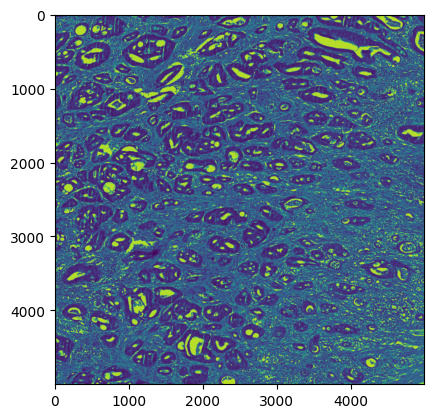

In [4]:
# Open the TIFF file
image = Image.open('Kather_texture_2016_larger_images_10/CRC-Prim-HE-01_APPLICATION.tif')

# Convert to a NumPy array
image = np.array(image)#[:500,:500]

# RGB to Grayscale
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
image = rgb2gray(image)

# Plot image
plt.imshow(image)
plt.show()

# Topological Image Segmentation

The segmentation method is based on topological data analysis, leveraging persistent homology to extract meaningful structures from an image. The process consists of multiple steps, including preprocessing, feature extraction, filtration, and final segmentation.

First, the input grayscale image is smoothed using a Gaussian filter with standard deviation $\sigma$ to reduce noise and enhance robustness:

\begin{equation}
I' = G_{\sigma} * I
\end{equation}

where $I$ is the original image, $G_{\sigma}$ is the Gaussian kernel, and $I'$ is the filtered image.

Next, persistent homology is applied to extract topological features. Using the \texttt{PixHomology} library, a persistence diagram $\mathcal{D}$ is computed, which captures the birth and death values of connected components and loops at different intensity thresholds:

\begin{equation}
\mathcal{D}, \mathcal{I} = \texttt{computePH}(I', \texttt{return\_index=True})
\end{equation}

where $\mathcal{D}$ contains the persistence pairs $(b, d)$, and $\mathcal{I}$ stores the spatial indices of these features.

To remove background noise, a filtration step is applied. The mean birth intensity of all detected features is computed as:

\begin{equation}
b_{\text{avg}} = \frac{1}{|\mathcal{D}|} \sum_{(b, d) \in \mathcal{D}} b
\end{equation}

Only features with $b > b_{\text{avg}}$ are retained, while weaker structures are suppressed by setting their birth values to $b_{\text{avg}}$. The lifetime of each feature, defined as $\ell = b - d$, is then used to filter out short-lived components. Features with $\ell$ greater than the mean lifetime are selected for segmentation.

For each selected feature, a region-growing segmentation is applied. A bounding box centered around the birth coordinate $(x_b, y_b)$ is extracted, and a binary mask is created to highlight pixels within the intensity range $[d, b]$. Connected component labeling is then used to assign distinct labels to segmented regions. The segmentation mask $S(x, y)$ is computed as:

\begin{equation}
S(x, y) =
\begin{cases}
    n+1, & \text{if } d \leq I(x, y) \leq b \text{ and part of the same component} \\
    0, & \text{otherwise}
\end{cases}
\end{equation}

where $n$ represents the region index.

The final segmentation output assigns a unique label to each detected structure, allowing for the identification of topologically significant regions within the image.


In [5]:
def topological_image_segmentation(image, sigma=2):
    # Gaussian filter
    image = ndimage.gaussian_filter(image, sigma=sigma)

    # PixHomology
    dgm, idxs = px.computePH(image, return_index=True)

    # Filtration
    background_level = dgm[:, 0].mean()
    filtered_dgm = dgm[dgm[:, 0] > background_level]
    filtered_idx = idxs[dgm[:, 0] > background_level]
    filtered_dgm[filtered_dgm < background_level] = background_level

    lifetime = filtered_dgm[:, 0] - filtered_dgm[:, 1]
    idx = np.where(lifetime > lifetime.mean())[0]
    idx = sorted(idx, key=lambda x: lifetime[x], reverse=True)

    # Segmentation
    height, width = image.shape

    segmentation = np.zeros_like(image)
    for n, i in enumerate(tqdm(idx)):
        b, d = filtered_dgm[i]
        yb, xb, yd, xd = filtered_idx[i]
        dim = np.max([np.abs(xb - xd), np.abs(yb - yd)])
        y_start = np.clip(yb - dim, 0, height)
        y_end = np.clip(yb + dim, 0, height)
        x_start = np.clip(xb - dim, 0, width)
        x_end = np.clip(xb + dim, 0, width)

        new_xb = xb - x_start
        new_yb = yb - y_start

        mask = (image[x_start:x_end, y_start:y_end] > d) * (image[x_start:x_end, y_start:y_end] <= b)

        label_mask, num_labels = ndimage.label(mask)
        obj = label_mask == label_mask[new_xb, new_yb]
        segmentation[x_start:x_end, y_start:y_end] += obj * (1 + n)
    return segmentation

segmentation = topological_image_segmentation(image)

100%|██████████| 13234/13234 [00:03<00:00, 3967.93it/s]


# Visualization

The extracted topological features are visualized to interpret the structure and complexity of tissue samples. Color maps and persistence diagrams are used to highlight significant patterns, aiding in the differentiation between healthy and cancerous regions.

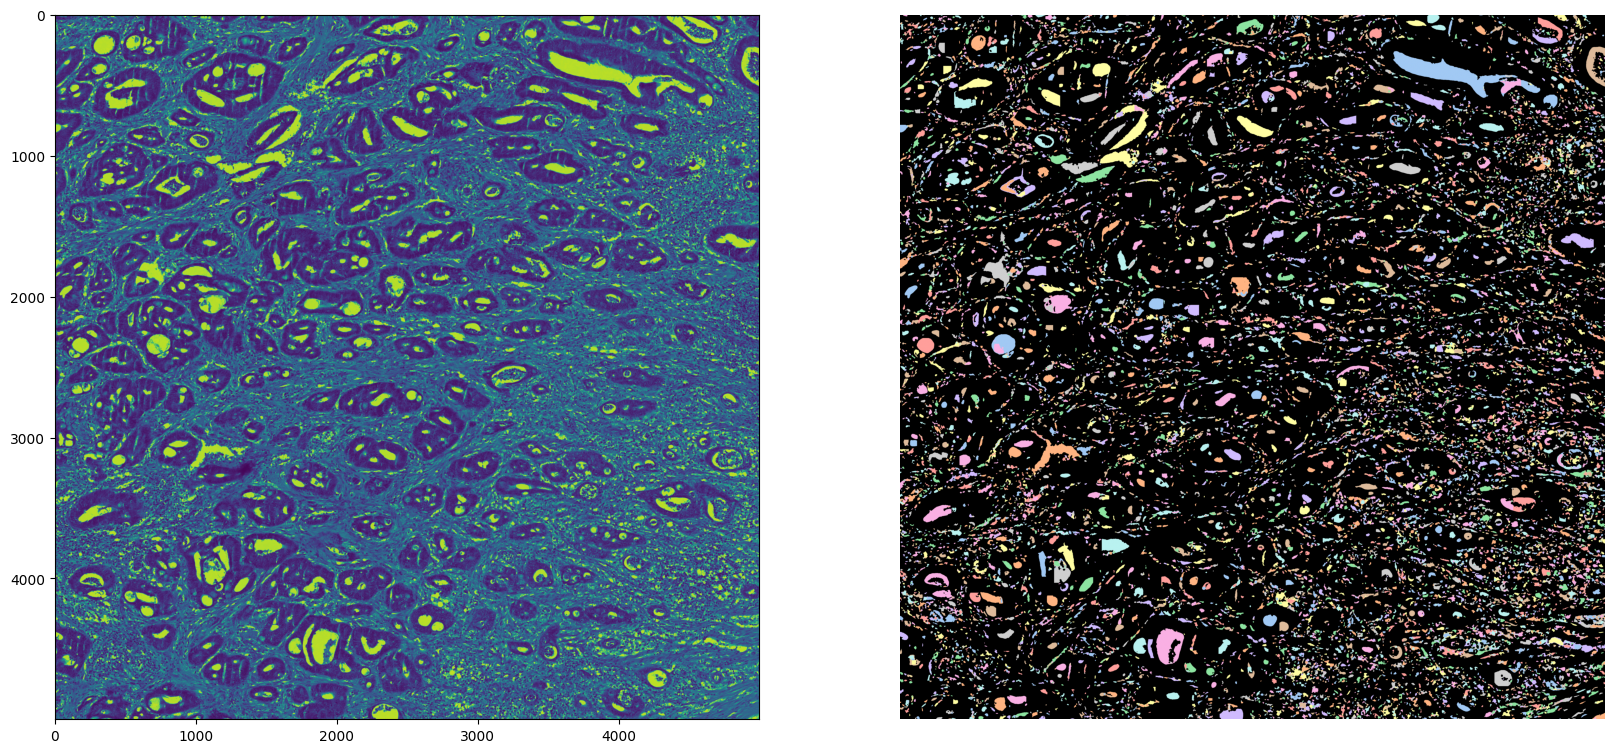

In [6]:
# Colors
num_classes = np.max(segmentation) + 1
pastel_colors = sns.color_palette("pastel", num_classes.astype(int))
pastel_colors = np.array(pastel_colors)

# Convert the segmentation map to an RGB image
colored_segmentation = label2rgb(segmentation, bg_label=0, colors=pastel_colors)

# Plot the colored segmentation
f, arr = plt.subplots(1, 2, figsize=(20, 10))
arr[0].imshow(image)
arr[1].imshow(colored_segmentation)
plt.axis('off')
plt.show()

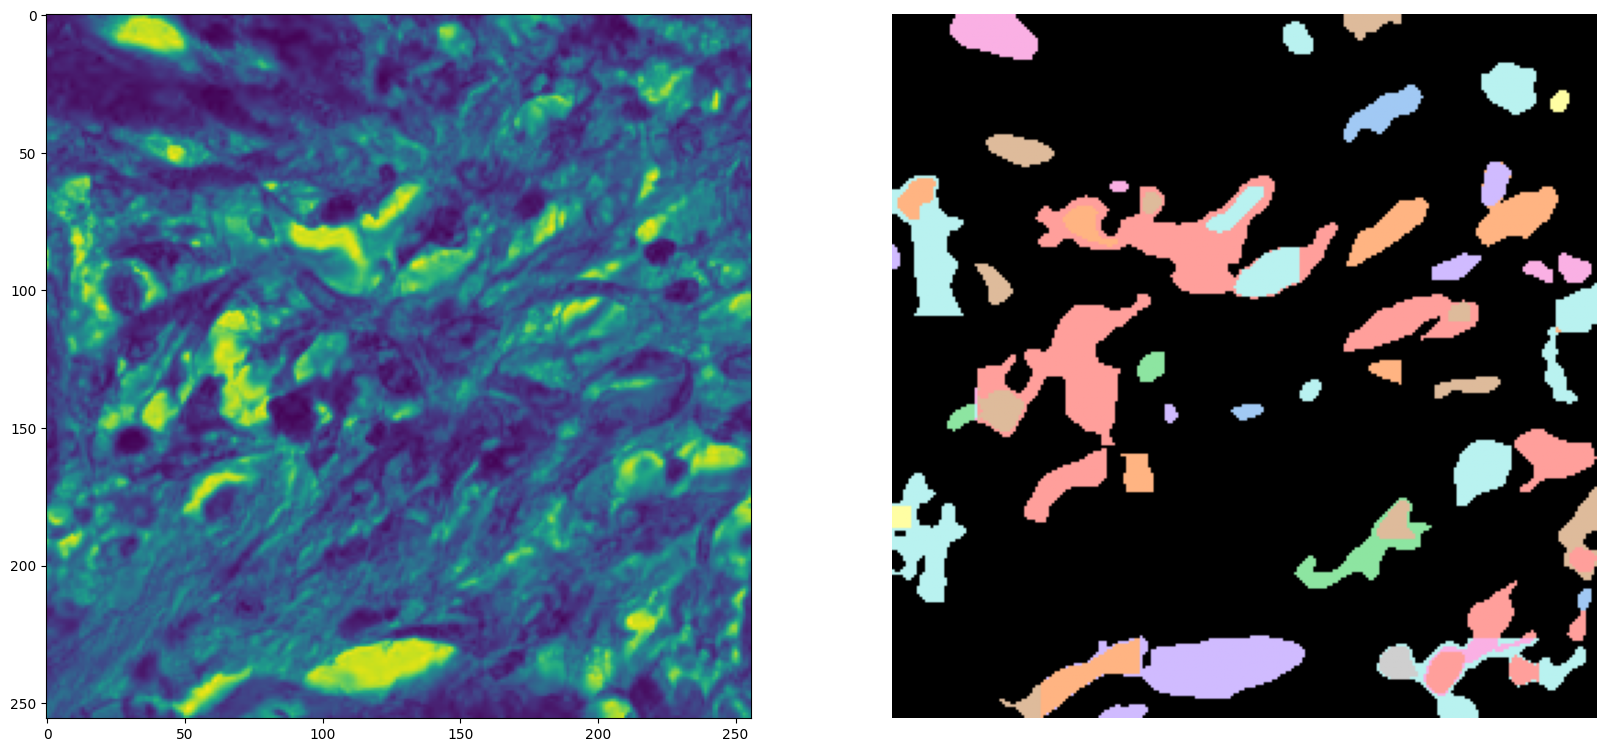

In [7]:
# Zoommed Plot the colored segmentation
f, arr = plt.subplots(1, 2, figsize=(20, 10))
arr[0].imshow(image[:256,:256])
arr[1].imshow(colored_segmentation[:256,:256])
plt.axis('off')
plt.show()